#  Extraction of  3D geometry from experimental mouse lung images 


## Introduction
The discovery of fundamental physical phenomena such as X-rays and MRI have produced the most
powerful diagnostic tools in medicine, with magnetic resonance imaging (MRI) and computed tomography
(CT) it is possible to create and use detailed images from inside the human body to determine Monitor
therapy for different types of situations in the abdomen, brain, chest, and pelvis. Images from these
devices are voxel volumes that can be viewed as slices, projections, and volume renderings. These images
must be accurate in order to be useful for health care. These images must therefore be improved,
segmented, and visualized after their generation. This report presents the different techniques that I
used for the processing and analyzing of the experimental images of mouse lungs which were digitized
with the Light sheets technique, and it also covers various limitations of the approaches and the 3D
geometric of these images.
It is organized into five chapters: introduction, mathematical background, segmentation, visualization,
and conclusion.


## Objectives of the project
The aim is to develop a numerical tool for extracting 3D geometry from experimental mouse lung images
obtained using C. Feral’s Light Sheets technique at IRCAN (Nice). Numerical tools are adapted from
tools already used in LJAD for human lung scanners. It should be applied to mouse lungs, which are
much smaller than human lungs, and light sheet technology to generate images with properties different
from scanners.


## Data


Digital images is a two-dimensional array of numbers and also a  two-dimensional functions. According to \cite{gonzalez2009digital} digital images are typically displayed on a cathode ray tube (CRT) or printed using some type of photo emulsion, and this explained why most display systems have nonlinear intensities features that give  a non-linear intensity profile of the image when display.

The source of the experimental mouse lung dataset is C.Feral’s Light sheet at IRCAN, and it is 3-dimensional unlabeled data of
size [1921,1861,858]. The scans have the space directions of [2.28509465,2.28509465,10] micron units and
they are of type uint16.

In [1]:
from src.thresholds import read_data, display_data

# load data
data, header = read_data("../input/essai03stitching_Subset.nrrd")

In [2]:
header

OrderedDict([('type', 'uint16'),
             ('encoding', 'raw'),
             ('endian', 'big'),
             ('dimension', 3),
             ('sizes', array([1921, 2861,  858])),
             ('space dimension', 3),
             ('space directions',
              array([[ 2.28509465,  0.        ,  0.        ],
                     [ 0.        ,  2.28509465,  0.        ],
                     [ 0.        ,  0.        , 10.        ]])),
             ('space units', ['microns', 'microns', 'microns'])])

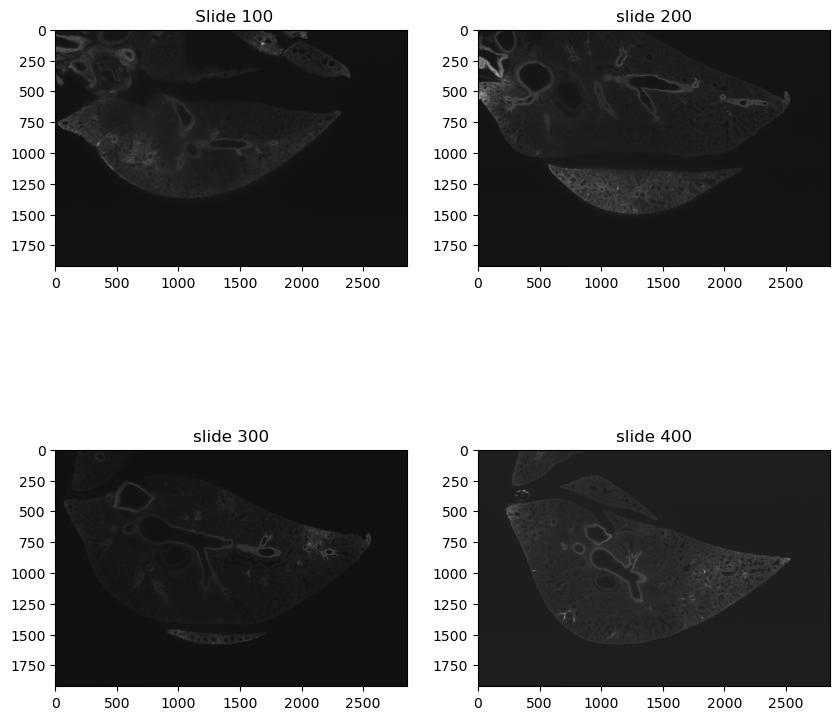

In [2]:
# display data
display_data(data[:, :,100],data[:, :,200],data[:, :,300],data[:, :,400])

One of the fundamental techniques in image processing is the concept of segmentation, which is the partitioning of the original set of pixels into subsets corresponding to the anatomical structures, and one could perform this task using techniques such as thresholding, mathematical morphology, and edge detection. I briefly introduced the definitions of segmentation and implement different segmentation techniques on the experimental image.

# Segmentation 

Segmentation is the process of determining boundaries and regions of interest from 3D image data, The
idea is to simply group pixels with similar visual properties. The goal of segmentation is to obtain an
accurate anatomical structure of the image data by removing the necessary regions of interest. There are
various segmentation methods.
In the first section, we tried to apply different approaches to thresholding and improve the results
using image morphological operations such as dilation, erosion, opening, and closing. 

Given a threshold $t$, let $I_{i,j}$ be the greyscale value of the images located at $(i,j)$. Then the thresholded image $g(x,y)$ is defined as:  

\begin{equation}
   g_{i,j} = \left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } I_{i,j}  \le t \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.
\end{equation}


### Manual Segmentation

To segment an image using the manual thresholding method, we convert such image into a binary image,
we only select our areas of interest and ignore the part that is not within our threshold value. I used the
Numpy method np.where(): this method returns one if the condition(threshold) is satisfied and returns
zero otherwise.

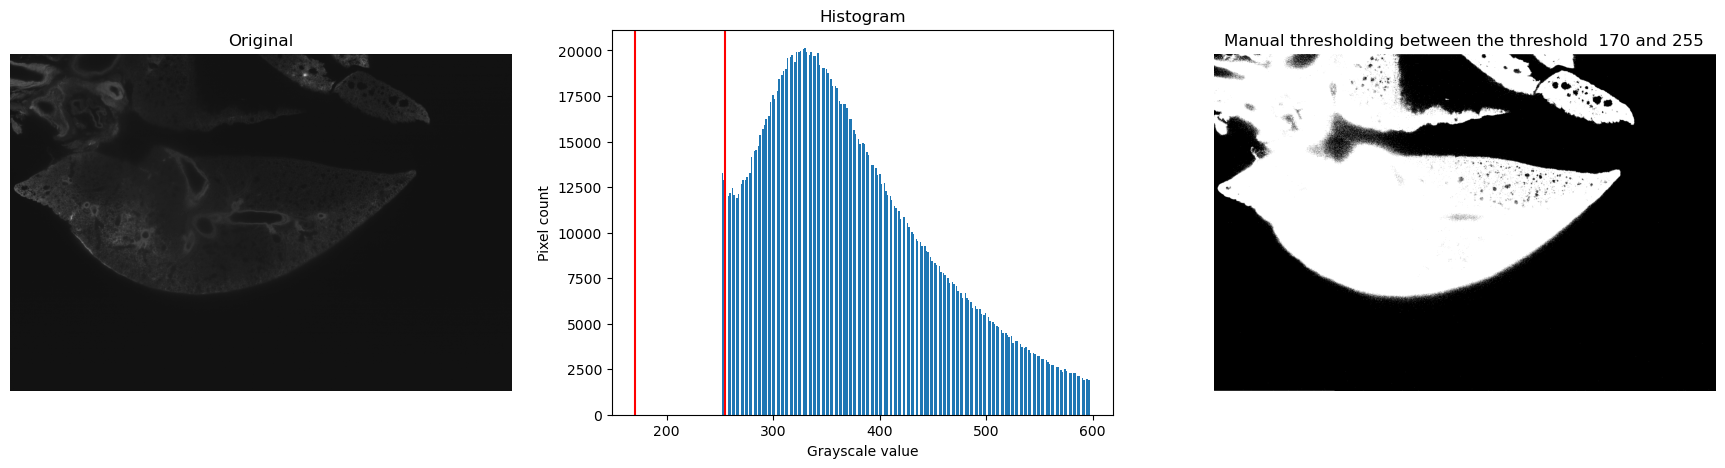

In [7]:
from src.thresholds import display_manual

# Display manual segmentation
display_manual(data[:,:,200])

Manual segmentation works well for some slides, but not so well for others like in the cell below, here we need a more robust method to iteratively select the optimal threshold for each image slide.

### OTSU SEGMENTATION

The Otsu segmentation method is based on the weighted distribution of background and foreground
pixels, the main idea of the algorithm is that it iteratively searches for a threshold that minimizes the variance within a class, defined as the weighted sum of the variances of the two classes (background and foreground). Let’s say your image has a grayscale between 0-250, you choose a threshold of 200, then all pixels with a value less than 200 will be the background, and all pixels with a value greater than or equal to 200 become the background, the algorithm then finds the within-class variance for all pixels with a threshold t, chooses the one with the smallest variance, and the formula for finding the within-class variance at a threshold t is:


$$\sigma^2(t)=W_{\mathrm{fg}}(t) \sigma^2(t)+W_{fg}(t) \sigma_{f g}^2(t) .$$

Where $W_{b g}(t)$ and $W_{f g}(t)$ is the probability  of the number of pixels for each class at threshold $t$ and $\sigma^2$ represents the Variance of color Values.


This method improves computational efficiency for optimal image thresholds. Here are the steps to
implement the Otsu algorithm.

* Step 1: Compute the histogram for image 2D.
* Step 2: Calculate the foreground and background variances for a single threshold.
    * i) Calculate the weight of the background and foreground pixels.
    * ii) Calculate the average of the background and foreground pixels.
    * iii) Calculate the variance of the background pixel and the foreground pixel.
* Step 3: Calculate "Intraclass Variance" using the formula above by [3].

I used the scikit-image Python package to implement the otsu threshold on the experimental image.
This method returns a threshold based on otsu. Below is the the implementation on our experimental image.



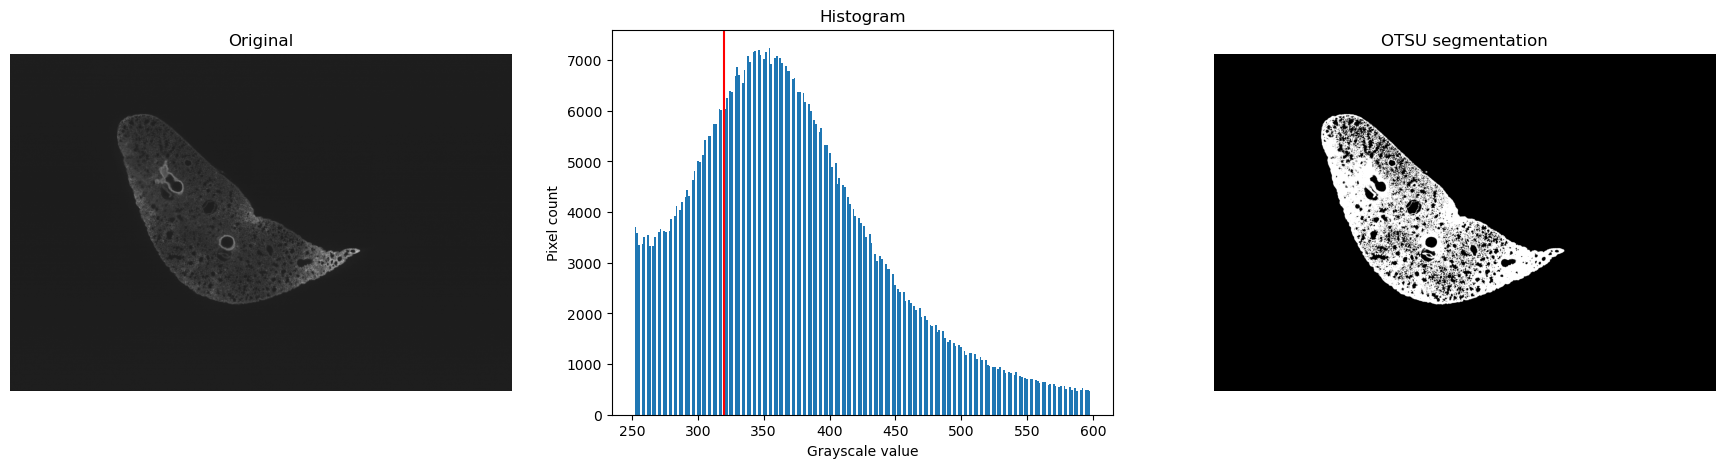

In [8]:
from src.thresholds import dislay_otsu
   
dislay_otsu(data[:,:,700])

Despite the simplicity and high accuracy of the OTSU, despite obtaining accurate segmentation on
most slides, this method still does not perform well on other slides as shown in the cell below. One of the reasons why we may have these shortcomings in this method may be as a result of noise in the experimental image. This then introduced us to the conceppt of image enhancement.

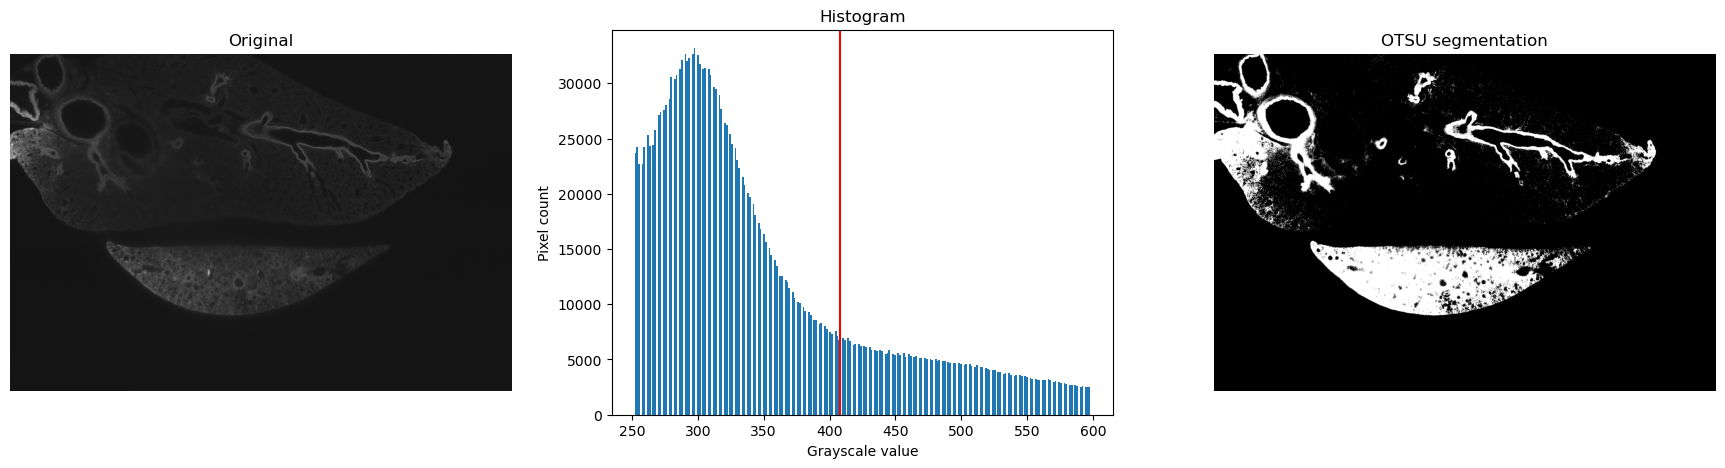

In [9]:
dislay_otsu(data[:,:,290])

### Image Enhancement 

Image enhancement is the process of magnifying the input image so that the processed image is more
visible to the human eye. It is a mapping from one image to another, the types of relationships between inputs and outputs are not unique and the improvement method is irreversible. One of the most common examples of image enhancement techniques is kernel or convolution.


### Local Operators
Local operators are operators that transform an image by giving each pixel a new value in a way that
only depends on that pixel and other nearby pixels. Many local operators are linear and they are implemented as kernel convolutions, some are nonlinear operators. Filter operators are commonly used for image enhancement:

##### Mean Filter
An average filter is a linear filter implemented as a local averaging operation that replaces the value of each pixel with the average of all values in its local neighborhood.
$$
w(s, t)=\frac{1}{m} \sum_{(s, t) \in N} f(s, t)
$$
where $m$ is the total number of pixels in the neighborhood $N$. 

##### Median Filter
Median filtering is a nonlinear noise reduction technique that has unique properties. It does not use convolution to process images with coefficient kernels, instead median filter passes through each image element, replacing each pixel with the median of its adjacent pixels, that is at each location in the kernel , a pixel from the input image contained in the frame is selected to be the output pixel located at the coordinates of the kernel center. Instead of replacing the pixel values with the average of the adjacent pixels, they are replaced with the median of those values. (If the affected neighborhood has an even number of pixels, the average of the two central pixels is used). The smoothing properties of the median filter are different from those of the averaging filter. Elements whose size is less than half the size of the median filter kernel are completely removed by the filter. Large discontinuities such as edges and large changes in image intensity can shift positions by a few pixels but are not affected by the median filter in terms of gray level intensity. This non-linear operation of the median filter can significantly reduce some types of noise. For example, "pepper and salt noise" can be completely removed from an image without losing important edges or image characteristics. 

##### Gaussian Filter 

Gaussian filters are a class of linear smoothing filters whose weight is chosen based on the shape of the Gaussian function. A Gaussian smoothing filter is a great filter for removing noise extracted from a normal distribution and, can be thought of as an uneven low-pass filter that keeps low spatial frequencies. 

A two-dimensional discrete Gaussian function with mean zero is defined:
$$
G(x,y)_\sigma=\frac{1}{2 \pi \sigma^2} e^{-\frac{\left(x^2+y^2\right)}{2 \sigma^2}}
$$



The cell below shows the result of applying the three different filters kernel of size 3 to the slide where OTSU method failed, I implemented the denoising process using the python OpenCV library and then moved on to using the otsu threshold.

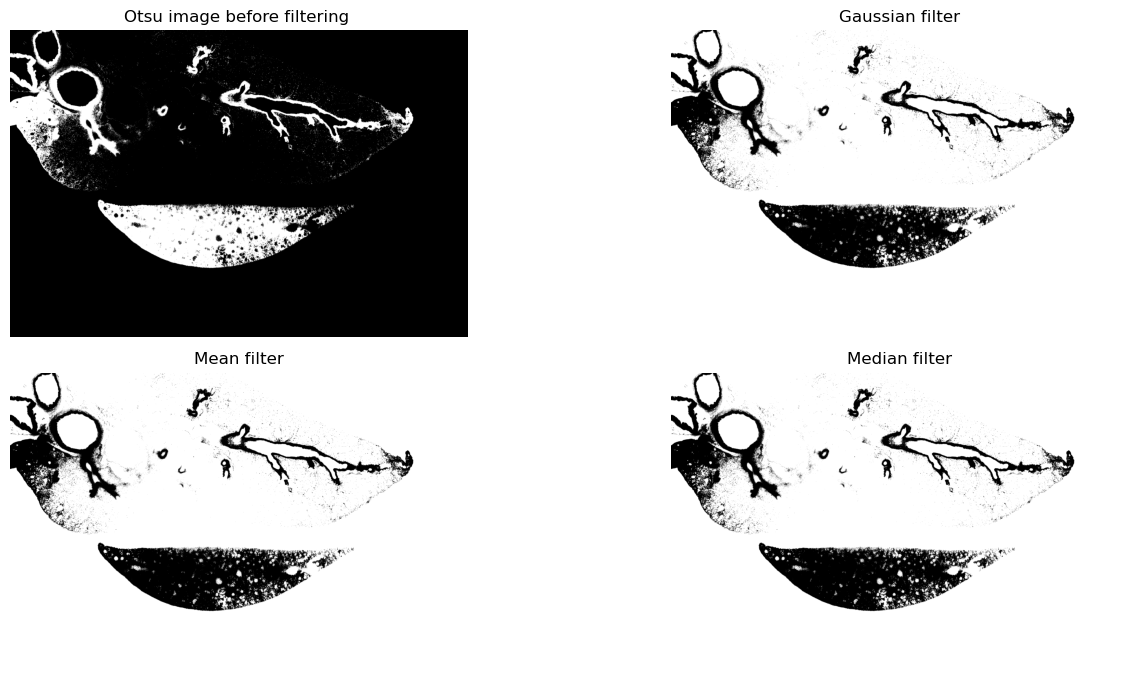

In [2]:
from src.thresholds import display_otsu_filter

display_otsu_filter(data[:,:,290])

The drawback with this method is its reliance on the intensity value, we can see from the cell above that the pixels in the bounding region are not segmented enough, and that is the problem, this could be because the illumination in the region have the smaller brighter part, therefore the OTSU thresholding is not ideal and therefore I considered the local thresholding.

 ##### Local Thresholding 

A threshold $\mathrm{T}(\mathrm{x}, \mathrm{y})$ is a value such that
$$
b(x, y)=\left\{\begin{array}{cc}
0 & \text { if } I(x, y) \leq T(x, y) \\
1 & \text { othenwise }
\end{array}\right.
$$
Where $\mathrm{b}(\mathrm{x}, \mathrm{y})$ is the binarized image and $\mathrm{I}(\mathrm{x}, \mathrm{y}) \in[0,1]$ be the intensity of a pixel at location $(\mathrm{x}, \mathrm{y})$ of the image I.


A local threshold calculation is performed for each pixel based on some local statistical variables, such as the range and variance of neighboring pixels. This can be done in a variety of ways, such as background removal, the mean and standard deviation of pixel values, and local image contrast. 
Unlike global thresholds, which use a single threshold for the entire image, local thresholds use unique thresholds for parts of the image that are derived from the entire image. In other words, the local threshold method uses different thresholds for individual regions of the image. This value is determined by the pixel's neighborhood to which the threshold is applied.

To implement this method on the experimental images of the lung, I  imported threshold_local from the scikit-image library, this function returns a threshold mask image according to the local pixel neighborhood. The threshold threshold_local is the weighted average of the area or location of pixels removed by the constant. I used the block_size of 35, the block_size n parameters is a sequence of  odd integers or an integer  of pixel neighborhood which is used to compute the threshold value, the adaptive threshold for the local neighborhood in the weighted mean image could be calculated using different methods ranging from 'generic', 'mean', 'gaussian' to the median, I used the default option which is 'gaussian' and this according to the documentation apply the gaussian filter. Lastly, I used an offset of 10, this means that 10 is deducted from the weighted mean to compute the local threshold value. 

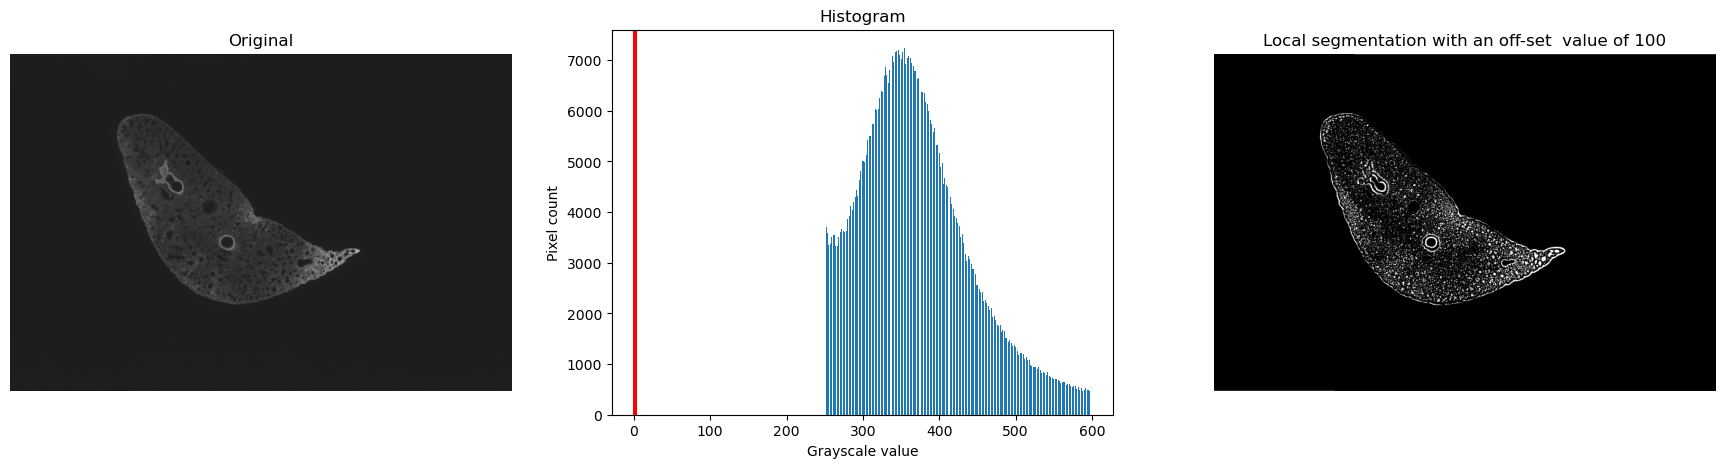

In [2]:
from src.thresholds import display_local

# Display local segmentation
display_local(data[:,:,700])

Part of the downside is that the method is very slow, which depends on the size of the area.  I tested a range of values from 0 to 100 randomly for the parameter offset, an off-set value of 100 seems to improve the segmentation, Figure 3.7 shows the implementation of the local threshold with an offset of 100. Next, I tried the mean threshold method.


### `MEAN SEGMENTATION`

Let  $y_{0}, y_{1}, \ldots, y_{n}$ be histogram, where $y_{i}$ is the number of pixels with the gray level $i$, and $n$ is the maximum gray level achieved.
let $t$ be a threshold value, Prewitt and Mendelsohn suggested that $t$ be chosen as the value of $i$ at which $y_{i}$ is minimize,in the valley between maxima of $y$. 
Supposed we could compute the partial sums below:

$$
A_{j}=\sum_{i=0}^{j} y_{i}, \quad B_{j}=\sum_{i=0}^{j} i y_{i}, \quad C_{j}=\sum_{i=0}^{j} i^{2} y_{i} \quad \text { for } j=0, \ldots, n
$$

So we can compute the average pixel value using $t$ as the integer part of $B_{n} / A_{n}$. For the mean threshold method, the threshold $t$ is chosen as the average value of the intensity distribution of pixel values.

For the implementation, I computed the mean threshold value by using the  scikit-image library, then use the NumPy function `where` to calculate the segmentation, this return 0, whenever each pixel of each slide is greater 0, then return 1 otherwise. Below is my implementation in Python.


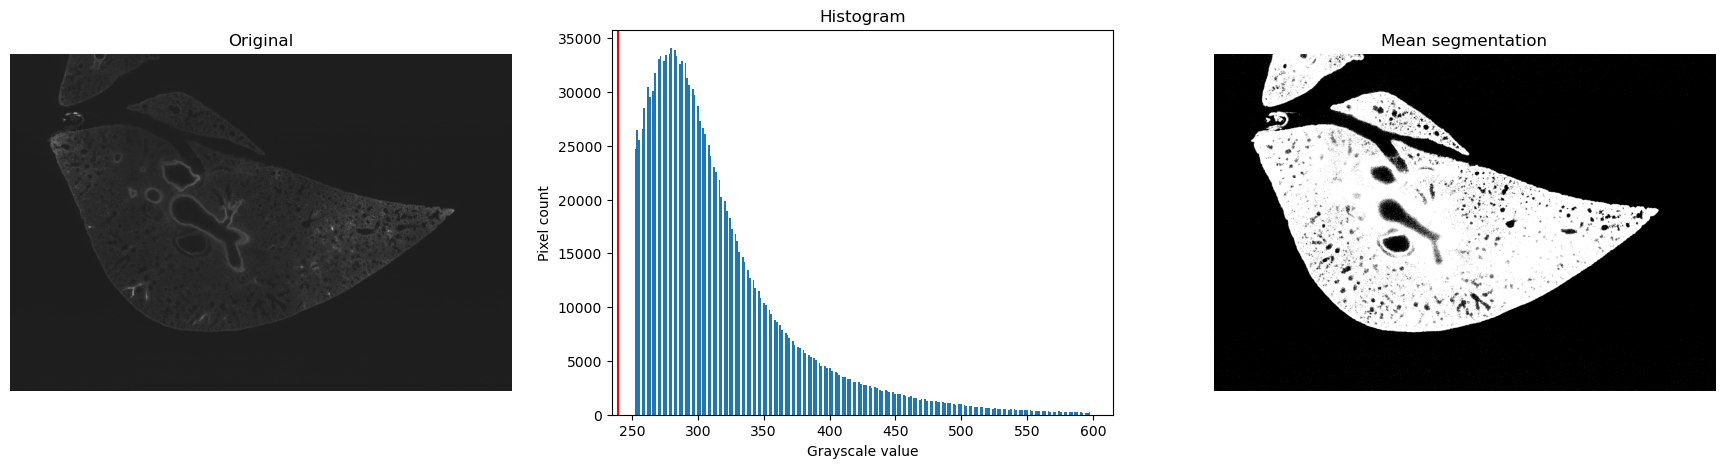

In [3]:
from src.thresholds import display_mean

display_mean(data[:,:,500])

The cell below shows the disadvantages of using the mean threshold method. This method added noise to a few of the slides after the segmentation. The cell below shows that after using the  three different denoising techniques, the segmentation improves. I then proceed to see if separating the pixels of the experimental image into distinct classes will give a perfect segmentation, and this brought the idea of Multi-otsu thresholding.

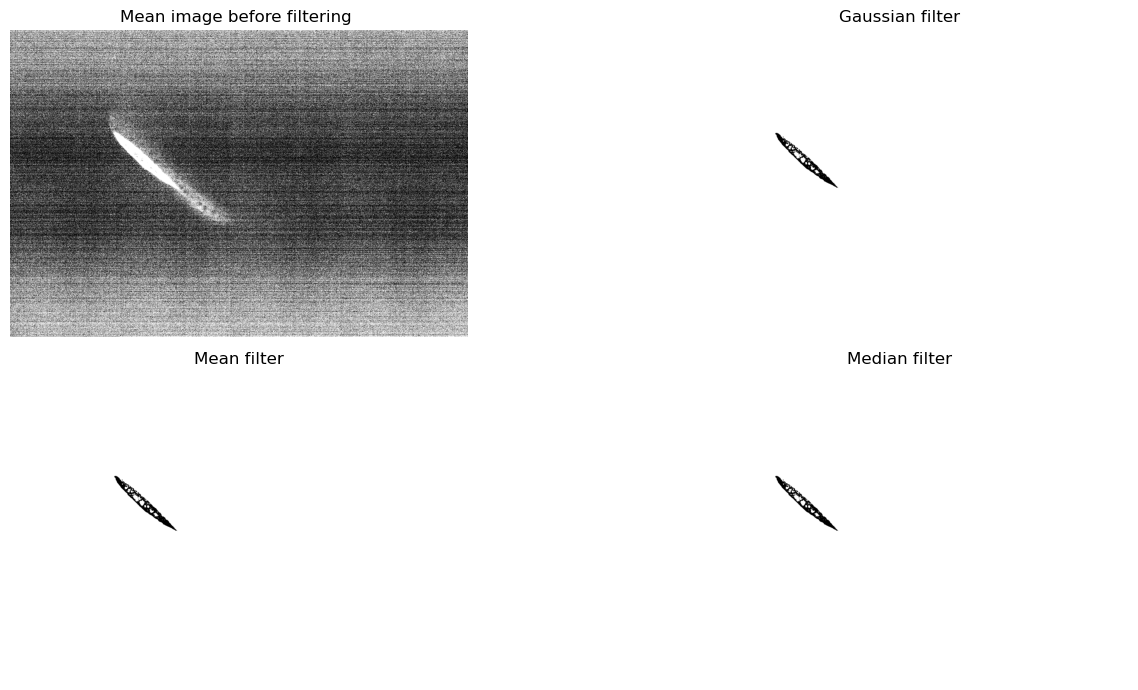

In [4]:
from src.thresholds import display_mean_filter

display_mean_filter(data[:,:,846])

### `MULTI-OTSU SEGMENTATION`

Unlike the Otsu threshold, where the gray-level image is split into two separate regions, in the multi-otsu method, the gray-level image is split into several different regions. This method divides the input image pixels into several different classes. Each class is acquired according to the gray level intensity of the image. This method returns more than one threshold for a given image and divides the image into some regions of brightness which are the background and some foreground (object).We use the mean and the variance of an image to find optimum thresholds for segmenting the image into multiple levels. I used the scikit-image library for the implementation of this multilevel thresholding on the experimental images of the lung, for the number of distinct classes, I used the default number of classes and the code implementation of this method  on the experimental image is given below.

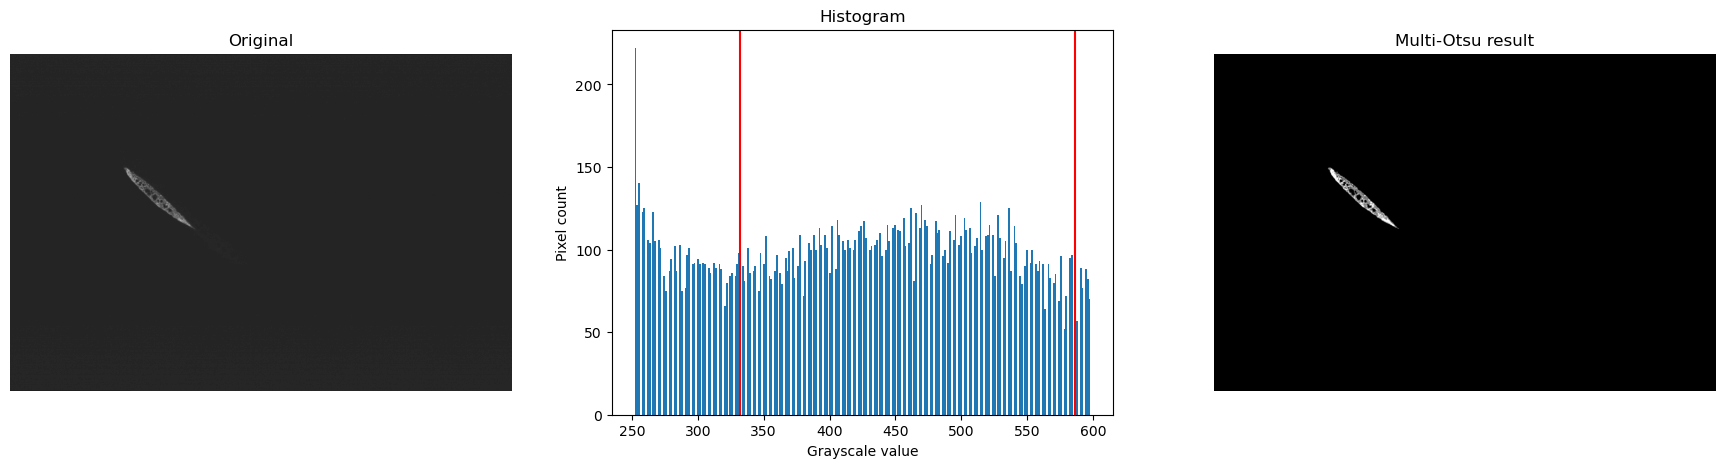

In [5]:
from src.thresholds import display_multiotsu
    
display_multiotsu(data[:,:,846])

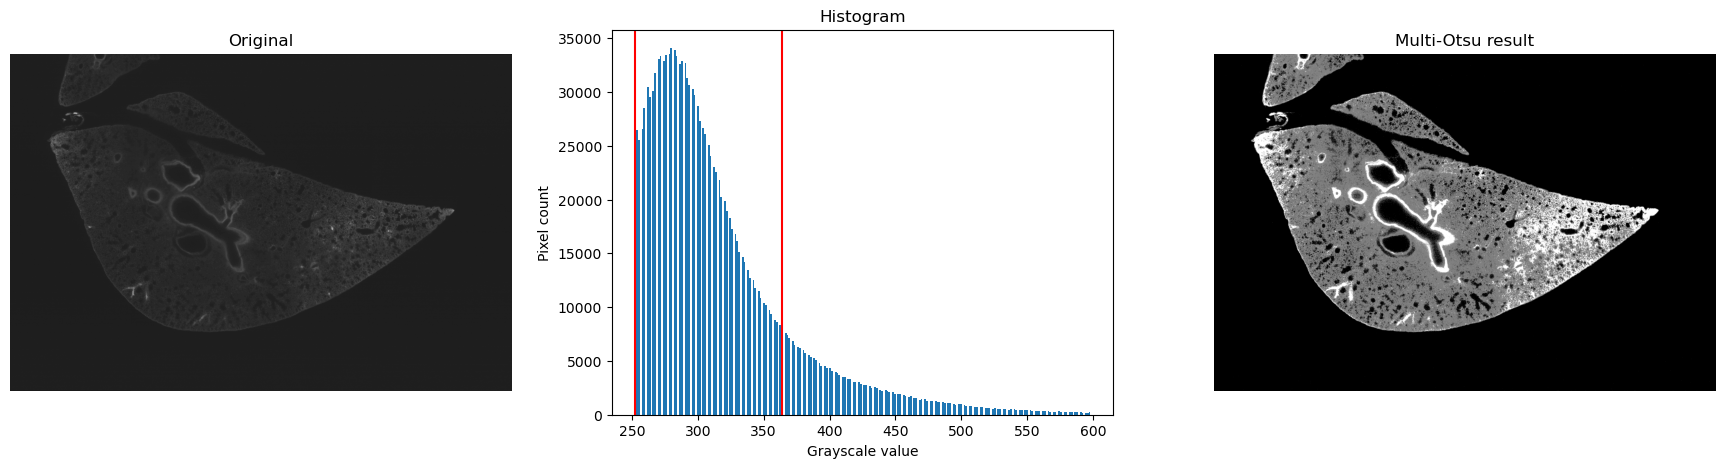

In [7]:
display_multiotsu(data[:,:,500])

The cells above show that the multi-otsu technique works well and goes further to improve the drawback of the mean segmentation method. Unfortunately, this method still have problem on  several slides. The cell below shows the drawback of the approach. I tried to see if using the filters to enhanced the images before doing the segmentation will work, unfortunately it doesnt work, and this lead to trying the statistical cluster technique.

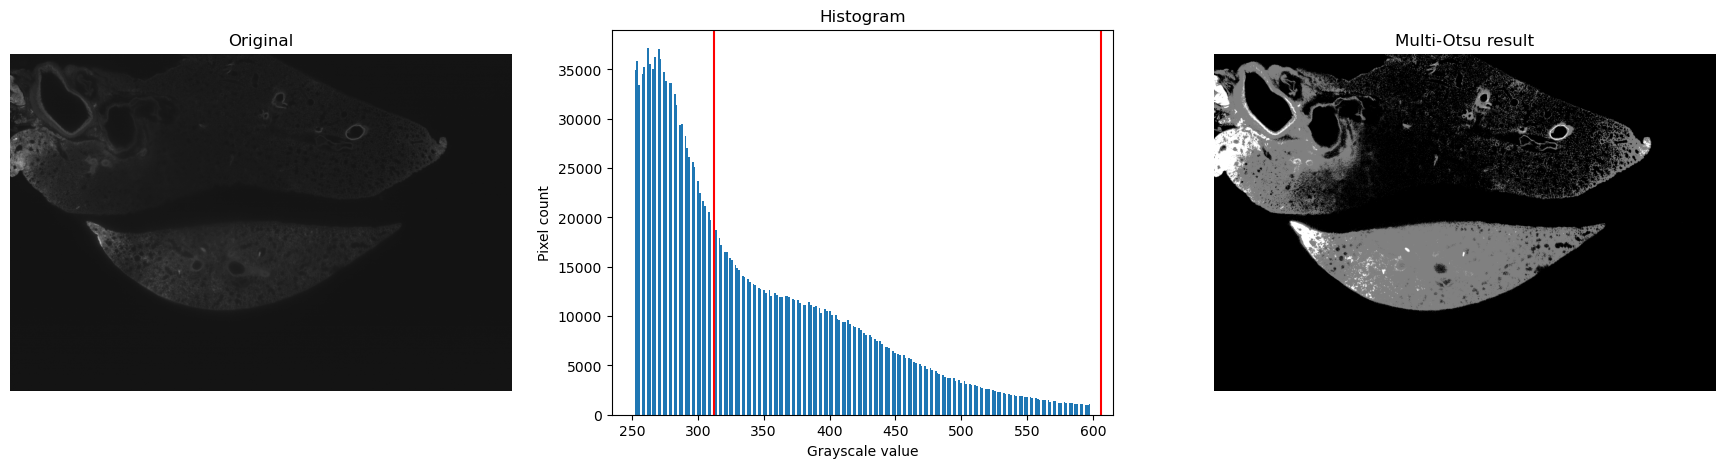

In [8]:
display_multiotsu(data[:,:,265])

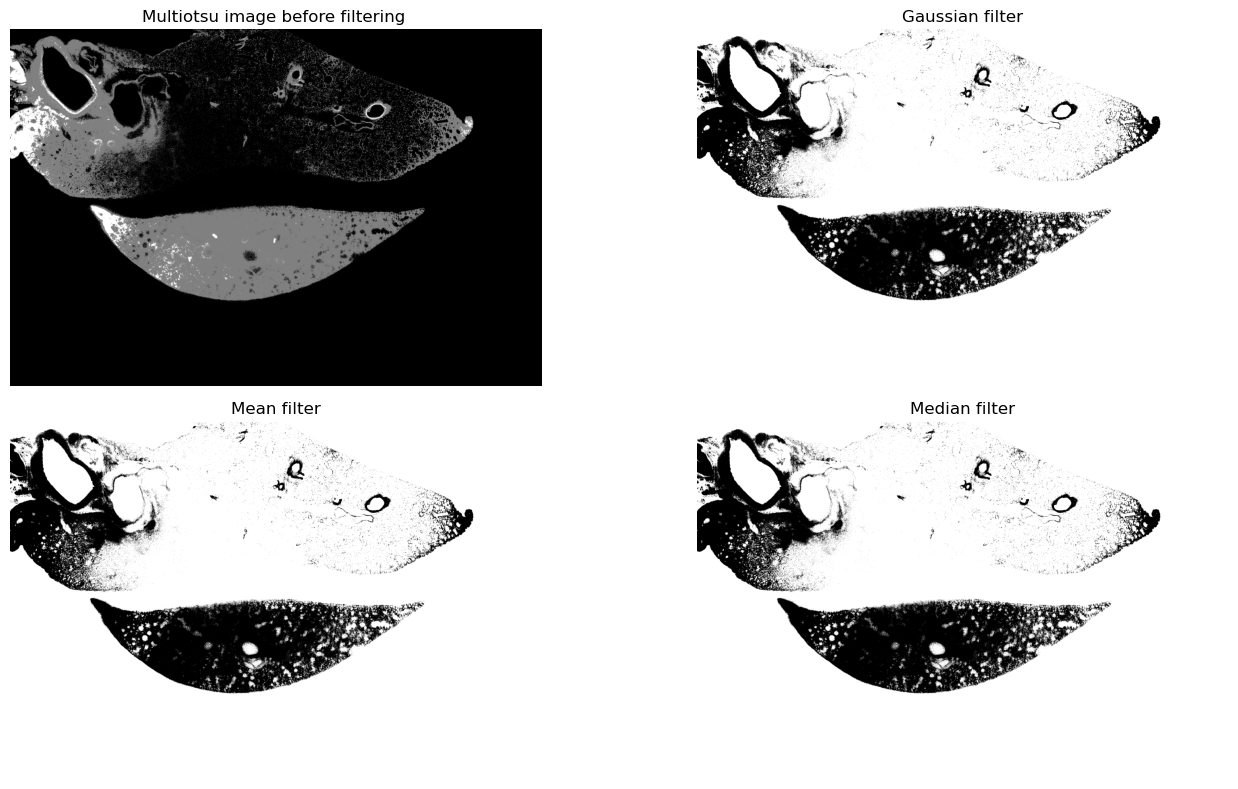

In [9]:
from src.thresholds import display_multiotsu_filter
    
display_multiotsu_filter(data[:,:,265])

### Gaussian Mixture Model (GMM)

### Introduction

Statistical cluster analysis is a data processing technique, it works by automatically grouping objects so that the objects in each group have similar attributes. The purpose of cluster analysis is to find groups of objects that are similar in a global sense. There is no way to know how many clusters are in your data before running the model. Cluster analysis is typically used when there are no assumptions about possible relationships in the data. It provides information about where the pattern exists in the data, but not what the pattern is or what it means. Clustering methods can be divided into two categories: probabilistic model-based approaches and non-parametric approaches. The assumption of probabilistic model-based techniques is that the data set follows a mixture model of probability distributions, then to cluster the data we can use the mixture likelihood.

For nonparametric approaches, clustering methods can be based on objective functions based on similarity or dissimilarity measures. These methods can be divided into hierarchical methods and partial methods. Hierarchical clustering is the procedure for transforming a data set into a dendrogram. The partitioning method uses a finite cluster prototype with a unique objective function representing the data set. Examples of partitioning methods include k-means, fuzzy c-means, and mean shift. 


A Gaussian mixture model is a probabilistic model that assumes that the data consists of combinations of individual Gaussians with unknown parameters. This method takes a set of Gaussian distributions, blends them in specific proportions, and then combines them to determine the original image.


One-dimensional Gaussian is defined as:
$$
\mathcal{N}(x \mid \mu, \sigma) \equiv \frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp \left(-\frac{(x-\mu)^{2}}{2 \sigma^{2}}\right)
$$\\


 The Gaussian distribution of the $d$ dimensional vector $X$ is characterized by the mean $\mu$ and the covariance matrix $\Sigma$. we used the following notation:
$$
X \sim \mathcal{N}(\mu, \Sigma)
$$
The  $X$ which is a random vector has a density $f$ if and only if its covariance matrix is invertible, in which case:

Random vector $X$ has density $f$ if and only if the covariance matrix is an invertible matrix. in this case:
$$
f(x)=\frac{1}{\sqrt{(2 \pi)^{d}|\Sigma|}} e^{-\frac{1}{2}(x-\mu)^{T} \Sigma^{-1}(x-\mu)}
$$
where $|\Sigma|$ is the determinant of $\Sigma$.\\


#### Gaussian mixture model
Now consider $k$ such distributions, with respective density functions $f_{1}, \ldots, f_{k}$ and respective parameters $\left(\mu_{1}, \Sigma_{1}\right), \ldots,\left(\mu_{k}, \Sigma_{k}\right)$. Let $\pi_{1}, \ldots, \pi_{k}$ be any probability distribution on $\{1, \ldots, k\}$ Select the $j$-th distribution with probability $\pi_{j}$, that is:
$$
X \sim \mathcal{N}\left(\mu_{Z}, \Sigma_{Z}\right) \quad \text { with } \quad Z \sim \pi .
$$
The vector $X$ has density:
$$
p_{\theta}(x)=\sum_{j=1}^{k} \pi_{j} f_{j}(x)
$$
where the parameter $\theta=(\pi, \mu, \Sigma)$ consists of:
- the mixing distribution $\pi=\left(\pi_{1}, \ldots, \pi_{k}\right)$,
- the set of means $\mu=\left(\mu_{1}, \ldots, \mu_{k}\right)$,
- the set of covariance matrices $\Sigma=\left(\Sigma_{1}, \ldots, \Sigma_{k}\right)$.


Since we are mixing different Gaussians together, we need a parameter for each Gaussian so that we can group our data. It is very important to know which samples each Gaussian belongs to so that we can evaluate these parameters. This is where maximizing expectations comes in. Expectation maximization is a technique used to cluster data according to the parameters of each Gaussian and estimate the same parameters for each sample. It is based on Gaussian variance, mean, and weight, and the samples belong to the same Gaussian. The cell below show the implementation of Gaussian Mixture Model.

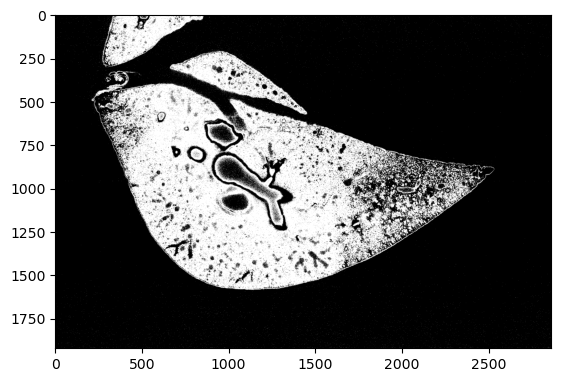

In [3]:
from  src.gmm import GMM

GMM(data[:,:,500])

Morphology is a set of image processing operations that process images based on shape. Morphology is used with two types of pixel sets, \textbf{objects}, and \textbf{structural elements}, it applies a structuring element to an input image, producing an output image of the same size. In the operation, the value of each pixel in the output image is based on a comparison of the corresponding pixel in the input image with its neighborhood. We can specify the structuring element as an object or background, the structuring element identifies the picture elements in an image being processed and defines the neighborhood that processes each pixel. Morphology uses the notion of reflection of set and set translation in relation to the structuring element.\\


### Dilation

Let $A$ be a set of pixels and let $B$ be a structuring element. Let $(\hat{B})_s$ be the reflection of $B$ about its origin and followed by a shift by $s$. Dilation, written $A \oplus B$, is the set of all shifts that satisfy the following:
$$
A \oplus B=\left\{s \mid(\hat{B})_s \cap A \neq \emptyset\right\}
$$
Equivalently,
$$
A \oplus B=\left\{s \mid\left((\hat{B})_s \cap A\right) \subseteq A\right\}
$$

The method of dilation increases the number of pixels with a value of 1 (foreground) and decreases the number of pixels with a value of 0 (background). Also, the process is primarily used to fill holes of missing pixels in a continuous object, and because the operation adds pixels to the boundaries of the object, it affects the intensity of that location and results in an observable blur. Therefore, it can be said that this is analogous to the smoothing of a spatial low-pass filter used for linear image filtering. 


###  Erosion

If   $A$ and $B$ are sets in erosion of $A$ by $B$, denoted $A \ominus B$, is defined as
$$
A \ominus B=\left\{z \mid(B)_z \subseteq A\right\}
$$
where $A$ is a set of foreground pixels, $B$ is a structuring element and the

Suppose $I$ is a  rectangular array of foreground and background pixels if $B$ is a structuring element, and the $z$’s are foreground values,  erosion of $I$ by $B$, then $A \ominus B$, as:\\
$$
I \ominus B=\left\{z \mid(B)_z \subseteq A \text { and } A \subseteq I\right\} \cup\left\{A^c \mid A^c \subseteq I\right\}
$$
 
Erosion operations complement the dilation operations in the context of computational effects. That is, the object loses its size due to the erosion operation. The action of erosion causes the object's edge pixels to be lost and it increases the number of zero-valued pixels (background) and decreases the number of unit-valued pixels (foreground). It also removes structures smaller than structural elements. So it can be used to remove noise  between two objects.


### Opening
The image opening operation is a combination of dilation and erosion operations. The opening  of  image A by the $\mathrm{B}$ structure element is defined as
$$
A o B=(\mathrm{A} \ominus \mathrm{B}) \oplus \mathrm{B}
$$
The definition above gives the relationship between opening and erosion and dilation. The opening operation is nothing more than the erosion of the image by the structuring element, and the resulting result is dilated by the same structuring element. An open operation smoothens the outline of an object, removes narrow connections, and also removes minor extensions on the object.

### Closing
Image closing is also a combination of erosion and dilation operations. It differs from the opening operation in the order in which the erosion and dilation operations are performed. Closing of image A by structural element B is defined as
$$
A \cdot B=(A \oplus B) \Theta B
$$

The relationship between erosion and dilation and closing is given in the mathematical formula above. This shows that the closing operation is the dilation of A with the $\mathrm{B}$ structuring element and the resulting image is eroded using the same structuring element. 


The cell below shows the result of using GMM and different morphological operations to segment the
image data. The output of erosion and opening work is very good but in figure 3.15 it all gets worsen.




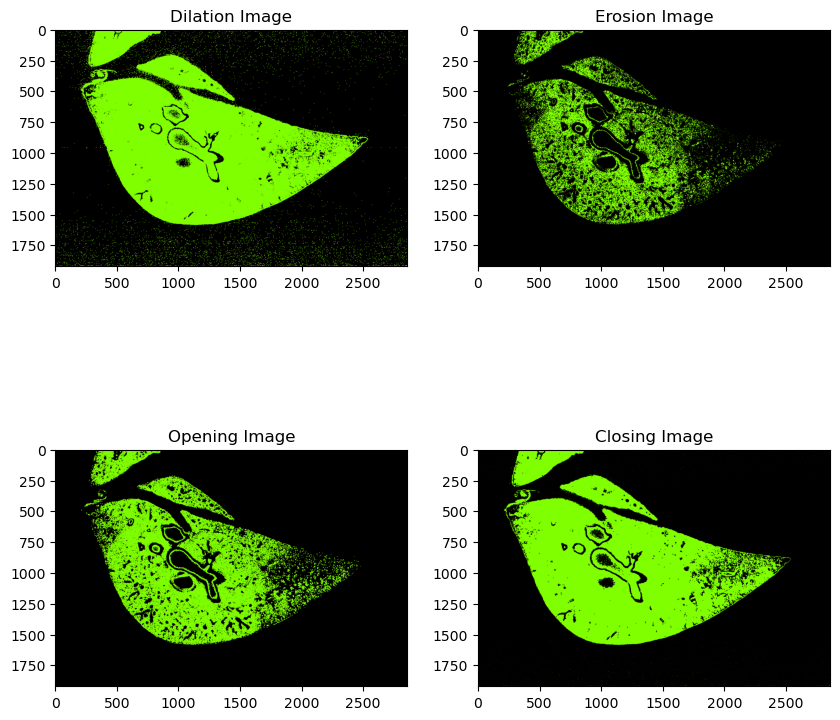

In [2]:

from src.gmm import display_morphology

display_morphology(data[:,:,500])

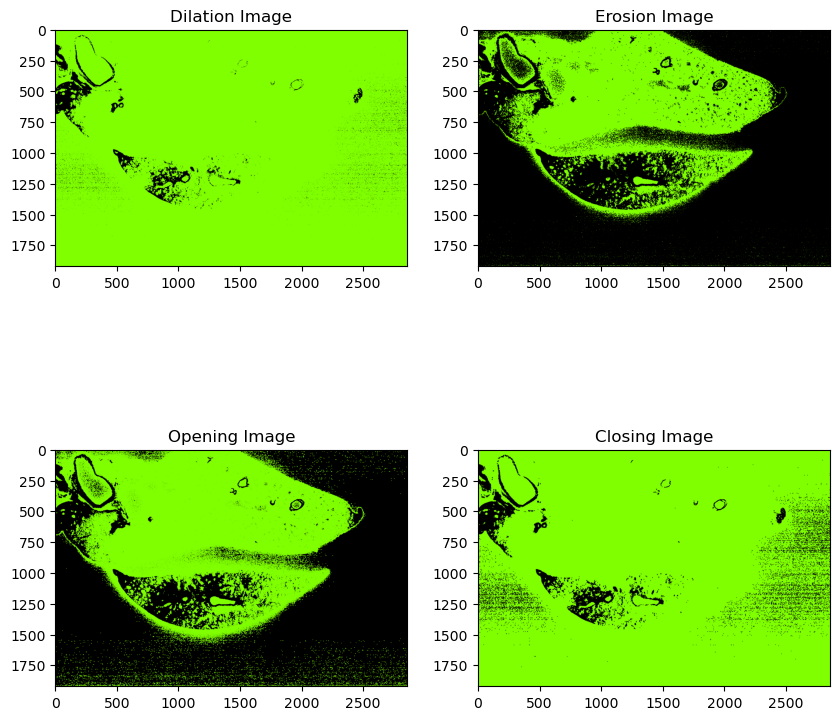

In [4]:
display_morphology(data[:,:,269])

### Watershed Segmentation

 A watershed is defined as the part of the land where all water flows to a common point in a stream, canal, lake, reservoir, or other body of water.
 A watershed is defined as the part of the land where all water flows to a common point in a stream, canal, lake, reservoir, or other body of water.

<img src= "img/watershed_schematic.jpeg" alt="A geographical watershed." style="width: 700px;height:400px;"/>


Watershed segmentation in image processing is a transformation technique that treats a grayscale image as a topographic relief, with the image intensity of each pixel equal to its height. For example, the background can be viewed as being lower in height, and areas with high valleys and strength can be represented as being taller, making it look like a mountain ridge. If you fill the topographic relief with water from a lower place and water from different sources does not meet together, divide the image into two separate sets: basins and watersheds, assuming that the watershed transformation is applied to the gradient of the image, and the watershed is assumed to be a uniform gray-level area of that image. The algorithm splits the image into several similar regions with the same gray level. It does this by finding the high-intensity gradient region that divides the adjacent local minima (basins). 

e<img src= "img/watershed.png" alt="Example of regional minima, watersheds and watersheds generated by the source of watershed transformation." style="width: 700px;height:400px;"/>


#### Implementation of Watershed Segmentation and K-Means clustering
To perform image segmentation on our mouse lung experimental dataset, I imported the following Python libraries.

I initially apply the watershed transformation directly to the image which actually produces  over-segmentation,and this according to [15] is as a result of noise or local irregularities in the gradient image, I first of all denoise the image using gausian filter of $\sigma=1$, and then change the type to \textit{uint8}.


Next, I find the edges of the array using the Canny edge operator of $\sigma=1$. The Canny Edge Detector is an edge detection operator that uses a multi-level algorithm to detect a variety of edges in images., this operator return the edges of our input image. Then applying the watershed transformation on this gradient of the image  will reduce the oversegmentation of the watershed algorithm.



Next,we compute the (euclidean) distance transform of the complement of the edges, by doing this, we convert our edges into a landscape. 

Watershed segmentation requires the selection of at least one marker interior to each object of the image, which includes the background as a different object. The markers can be chosen by an operator or by an automatic procedure that considers the application knowledge of the objects.
We create markers to be used as seeds for the watershed at the local maxima in the distance transformed image, using the scikit-image method \textit{measure. label} which returns the label connected regions of an integer array.



Once the objects are marked, then we can grow them using a morphological watershed transformation, to perform this task, I again used the scikit-image method \textit{watershed} and this according to the documentation find the watershed basins in image flooded from given markers.


After computing the labels, We would identify where the labels are in the source image, to find those labels within our image, we use the scikit-image \textit{regionprops} and this method returns the measurement of  the properties of labeled image regions. We want our segmentations to be represented as images of the same size as the original image containing integer labels. I convert and reshape the \textit{region-means} so it can meet up with the requirement for the next step.


Next, we applied K-Means clustering, the clustering method was applied to obtain an image of different intensity regions based on the  minimum distance to examine each pixel of the image and then assign it to one of the image clusters. We want this process to be automated which is why we are using  K-means in order to do clustering of the background and the foreground intensities.



Next, we make a prediction of  the label for each of the regions, and it will return the label foreground or background.



Lastly, we label the image appropriately, that is relabelling the coordinate according to the coordinate of each region and assign that to whether is background or foreground.


These method performs perfectly on all the 847 slides of the experimental image of the lung and could be seen correcting all the drawbacks of the previous techniques used. Hence I have my segmentation. 


/Users/suleimanadebowaleojo/Desktop/medical images/Lungs project/project to gits/src/watershed.py:27: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = feature.peak_local_max(dt, indices=False,min_distance=5)


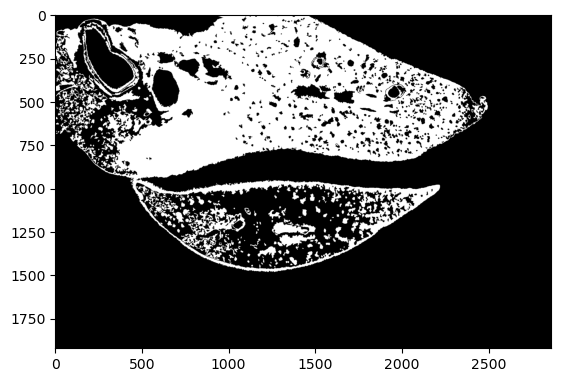

In [5]:

from src.watershed import display_watershed

# Display watershed segmentation
display_watershed(data[:,:,269])

In [5]:
display_watershed(data[:,:,500])

NameError: name 'display_watershed' is not defined

In [ ]:
display_watershed(data[:,:,700])

In [ ]:
display_watershed(data[:,:,845])

These method performs perfectly on all the 847 slides of the experimental image of the lung and could
be seen correcting all the drawbacks of the previous techniques used. Hence I have my segmentation.

## Visualization

#### Introduction

The medical environment poses newer challenges that require modern techniques, therefore, a shift in the traditional craftsmanship brought about the Visualization approach which offers multidimensional solutions in terms of diagnosis and treatment of diseases. This visualization medicine has not only increased the quality of medical treatment but makes them cost-effective and smart. Modern medicine is able to deploy real-time video graphics throughout the course of medical procedures that could even see patients viewing with enthusiasm which offers some forms of palliation. Successes recorded in recent time has shown the significance of visual medicine which guide physicians through medical treatment and subsequent follow-up, it is highly critical to employ this method in the modern approach to cancer and other deadly and expensive diseases.

#### Surface Visualization
Volume rendering is a technique for rendering a projection of a 3D volume into a 2D image. 

After obtaining an ideal segmentation technique (watershed and K-means) that works well for experimental images of the mouse lung, segment each slide in the data set, Next is to  create a 3D surface to characterize the image data using the Marching Cubes, the advantage of this method is that it provides a fairly detailed surface representation of our  object of interest, especially  now that our image data has been  segmented. But given the amount of data I have, the computational load is very high. Creating new surfaces is computationally intensive and causes a lot of delays in my work, and displaying them all can cause graphics issues. I initially started this with a python package \textbf{PyVista}, to solve this problem and to take into account the time constraints of sending and presenting this report, I resize the data, use the segmentation method discussed, then use ITK-snap and 3Dslicer to display the results of these two programs.


<div>
<img src="img/itk2.png" alt=" Bridge in Brooklyn" style="width: 1000px;height:500px;"/>
<img src="img/itk3.png" alt="Eiffel Tower in Paris, France" style="width: 1000px;height:500px;"/>
<p>The 3-Dimensional visualization of a sample of the experimental image of the mouse lung
using ITK-Snap</p>
</div>




<div>
<img src="img/slicer1.png" alt=" Bridge in Brooklyn" style="width: 1000px;height:500px;"/>
<img src="img/slicer2.png" alt="Eiffel Tower in Paris, France" style="width: 1000px;height:500px;"/>
<p>The 3-Dimensional visualization of a sample of the experimental image of the mouse lung
using 3D Slicer</p>

</div>



# Conclusion
Of all the methods that I have implemented on the experimental image of the mouse lung to separate the foreground from the background, the watershed method together with the k-means method is the only approach that gives an accurate segment of the image data as shown clearly in figure 3.20, where this approach correct all the drawbacks from the other methods. The image data were preprocessed using a Gaussian filter to enhance it and a canny edge detector to find the edges of the images. We then proceed to use the watershed to find the labels and then used the k-means method to automatically do the clustering of the background and the object, the results of this process are shown in figure 3.18 and figure 3.19. Finally, due to a large amount of data and the high computational load of creating a 3D surface I used ITK-SNAP and 3Dslicer in volume rendering of the scaled sample of the data. 